In [2]:
from evolufy.investment_strategy import ModernPortfolioTheory
from evolufy.information import *
from evolufy.data_sources import *
import numpy as np
np.random.seed(0)
from dacite import from_dict
from darts import TimeSeries

In [4]:
ds = DataServices([Filesystem("datasets/prices/AC.json", "datasets/prices/ACCELSAB.json")], information=NaiveMarketValuation)
information = await ds.request()

<Axes: xlabel='time'>

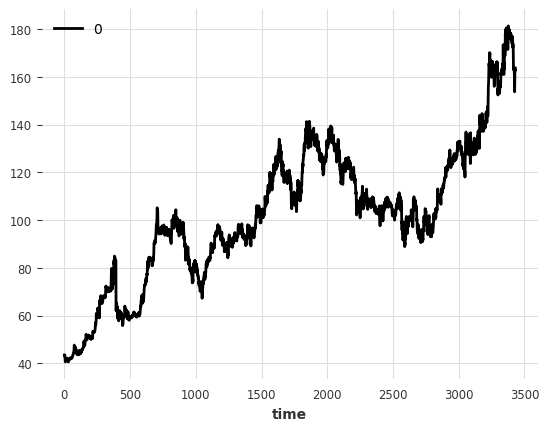

In [5]:
information.assets[0].market_prices.plot()

<Axes: xlabel='time'>

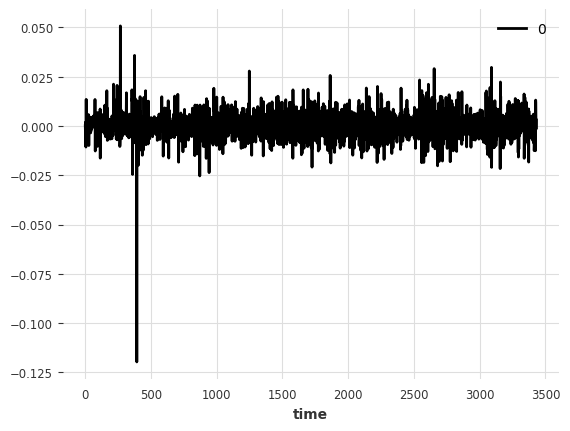

In [6]:
returns = information.assets[0].explore_returns()
returns.plot()

In [10]:
from cvxopt import matrix
from cvxopt import solvers
q=1
expected_returns_ = matrix(-q*np.mean(returns, axis=1), tc="d")
covariance_matrix_ = matrix(2*np.cov(returns), tc="d")
np.cov(returns),np.mean(returns, axis=1)

(array([[ 7.73374092e-05, -3.08728892e-05],
        [-3.08728892e-05,  4.89189515e-05]]),
 array([-0.00222383,  0.0006438 ]))

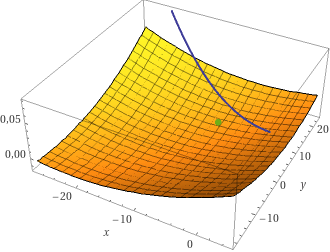

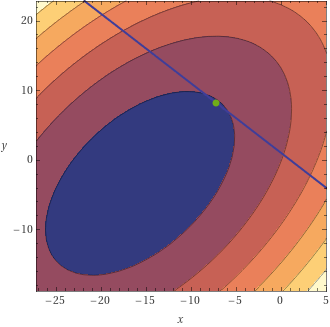

In [11]:
from cvxopt import matrix
from cvxopt import solvers
q = 1
# https://www.wolframalpha.com/input?i=%5B%2F%2Fmath%3AMIN%2F%2F%5D+%5B%2F%2Fmath%3A7.73374092e-05x%5E2%2B4.89189515e-05y%5E2-0.0000617457784xy%2B0.00222383x-0.0006438y%2F%2F%5D+subject+to+%5B%2F%2Fmath%3Ax%2By%3D1%2F%2F%5D&lang=es
expected_returns = np.mean(returns, axis=1)
expected_returns_ = matrix(-q*expected_returns, tc="d")
covariance_matrix_ =  matrix(2*np.cov(returns), tc="d")
# https://courses.csail.mit.edu/6.867/wiki/images/a/a7/Qp-cvxopt.pdf
A = matrix(np.ones((1,2)), tc="d")
b = matrix(1.0)
solution = solvers.qp(P=covariance_matrix_,q=expected_returns_,A=A,b=b)
solution['primal objective'], np.array(solution['x'])

(-0.010346747121549146,
 array([[-7.20215642],
        [ 8.20215642]]))

In [12]:
np.all(np.linalg.eigvals(covariance_matrix_) > 0)

True

In [18]:
w_opt = np.array(np.array([-7.20215642, 8.20215642]).T)
covariance_matrix = np.cov(returns)
ERp_opt = w_opt@expected_returns
varRp_opt = w_opt@np.cov(returns)@w_opt.T
stdevRp_opt = np.sqrt(varRp_opt)
(varRp_opt-q*ERp_opt)

-0.010346747121549147

In [19]:
n = 100
w1 = np.linspace(9, -8, n)
w2 = np.linspace(-8, 8, n)
w = np.vstack((w1,w2)).T

ERp = w@expected_returns
varRp = (w@covariance_matrix@w.T).diagonal()
stdevRp = np.sqrt(varRp)
U = lambda w,q: q*ERp[w]-varRp[w]

def optimize_max(q):
    variance_boundary = [U(w,q) for w in range(0,n)]
    arg = np.argmax(variance_boundary)
    return arg,variance_boundary[arg],q

def optimize_min(q):
    variance_boundary = [-U(w,q) for w in range(0,n)]
    arg = np.argmin(variance_boundary)
    return arg,-variance_boundary[arg],q

def efficient_frontier():
   efficient_frontier = []
   for q0 in range(0,1000):
     arg,u,q = optimize_max(q0)
     efficient_frontier.append([stdevRp[arg], ERp[arg]])
   return np.array(efficient_frontier).T

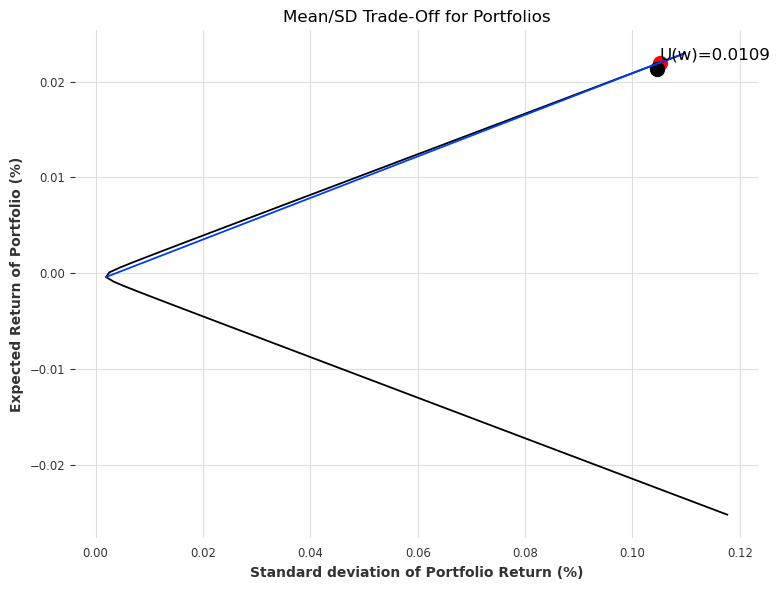

In [20]:
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 6))
plt.plot(stdevRp, ERp)
X,Y = efficient_frontier()
plt.plot(X, Y)
plt.xlabel('Standard deviation of Portfolio Return (%)')
plt.ylabel('Expected Return of Portfolio (%)')
plt.title('Mean/SD Trade-Off for Portfolios')
arg, u, q = optimize_max(1)
plt.scatter(stdevRp[arg], ERp[arg], color='red', s=100)
plt.text(stdevRp[arg], ERp[arg], f'U(w)={u:.4f}', fontsize=12, verticalalignment='bottom')
plt.scatter(stdevRp_opt, ERp_opt, s=100)
plt.grid(True)
plt.tight_layout()
plt.show()

# Visualization

In [399]:
# https://ocw.mit.edu/courses/15-401-finance-theory-i-fall-2008/dd628e151309a7f23962b1a31b9356e5_MIT15_401F08_lec13.pdf

expected_returns = np.array([1.08, 1.75])
covariance_matrix = np.array([
    [6.32**2,0.37*9.73*6.23],
    [0.37*9.73*6.23,9.73**2]
])
covariance_matrix

array([[39.9424  , 22.428623],
       [22.428623, 94.6729  ]])

In [382]:
n = 100
w1 = np.linspace(3, -2, n)
w2 = np.linspace(-2, 3, n)
w = np.vstack((w1,w2)).T

ERp = w@expected_returns
varRp = (w@covariance_matrix@w.T).diagonal()
stdevRp = np.sqrt(varRp)
U = lambda w,q: q*ERp[w]-stdevRp[w]

def optimize_max(q):
    variance_boundary = [U(w,q) for w in range(0,n)]
    arg = np.argmax(variance_boundary)
    return arg,variance_boundary[arg],q

def optimize_min(q):
    variance_boundary = [-U(w,q) for w in range(0,n)]
    arg = np.argmin(variance_boundary)
    return arg,-variance_boundary[arg],q

def efficient_frontier():
   efficient_frontier = []
   for q0 in range(0,100):
     arg,u,q = optimize_max(q0)
     efficient_frontier.append([stdevRp[arg], ERp[arg]])
   return np.array(efficient_frontier).T

In [369]:
q = 100
optimize_max(q), optimize_max(q) == optimize_min(q)

((99, 281.7478033178975, 100), True)

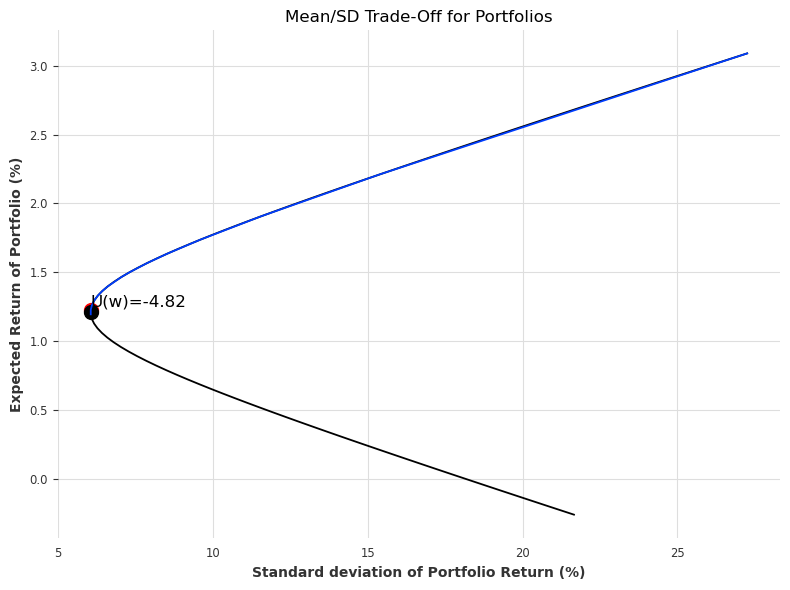

In [383]:
plt.figure(figsize=(8, 6))
plt.plot(stdevRp, ERp)
X,Y = efficient_frontier()
plt.plot(X, Y)
plt.xlabel('Standard deviation of Portfolio Return (%)')
plt.ylabel('Expected Return of Portfolio (%)')
plt.title('Mean/SD Trade-Off for Portfolios')
arg, u, q = optimize_max(1)
plt.scatter(stdevRp[arg], ERp[arg], color='red', s=100)  # s is size of the point
plt.text(stdevRp[arg], ERp[arg], f'U(w)={u:.2f}', fontsize=12, verticalalignment='bottom')
plt.scatter(stdevRp_opt, ERp_opt, s=100)
plt.grid(True)
plt.tight_layout()
plt.show()

In [384]:
# wolframalpha.com/input?i=%5B%2F%2Fmath%3AMIN%2F%2F%5D+%5B%2F%2Fmath%3A39.9424x%5E2%2B94.6729y%5E2%2B44.857246xy-1.08x-1.75y%2F%2F%5D+subject+to+%5B%2F%2Fmath%3Ax%2By%3D1%2F%2F%5D&lang=es
w_opt = np.array(np.array([0.801146, 0.198854]).T)
ERp_opt = w_opt@expected_returns
varRp_opt = w_opt@covariance_matrix@w_opt.T
stdevRp_opt = np.sqrt(varRp_opt)
(varRp_opt-q*ERp_opt)

(35.313093545618855, -4.820160259939237)

In [388]:
varRp[arg], ERp[arg]

(36.59099560493828, 1.228888888888889)

In [398]:
from cvxopt import matrix
from cvxopt import solvers
q = 1
expected_returns_ = matrix(-q*expected_returns, tc="d")
covariance_matrix_ = matrix(2*covariance_matrix, tc="d")
# https://courses.csail.mit.edu/6.867/wiki/images/a/a7/Qp-cvxopt.pdf
A = matrix(np.ones((1,2)), tc="d")
b = matrix(1.0)
solution = solvers.qp(P=covariance_matrix_,q=expected_returns_,A=A,b=b)
solution['primal objective'], np.array(solution['x'])

(35.31309354560953,
 array([[0.80114568],
        [0.19885432]]))

In [ ]:
! git 